In [1]:
# !pip install torch
# !pip install torchvision

In [1]:
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(torch.__version__)

2.6.0


# Data Loading

[data] Air Quality 

https://archive.ics.uci.edu/dataset/360/beijing+multi+site+air+quality+data

- 베이징 12개 지역의 대기 오염 (미세먼지, 온도, 습도 등) 시계열 데이터 
- 변수 설명은 관련 링크 통해 상세 확인

- 해당 파일에서는 CO(GT)를 타겟으로 함 <- 일산화탄소 농도

In [3]:
file_path = "./data/AirQualityUCI.csv"

In [4]:
_df = pd.read_csv(file_path, sep=";")
_df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


# Preprocessing

In [5]:
df = _df[["Date", "Time", "CO(GT)"]]
df.head()

,Date,Time,CO(GT)
0,10/03/2004,18.00.00,"2,6"
1,10/03/2004,19.00.00,2
2,10/03/2004,20.00.00,"2,2"
3,10/03/2004,21.00.00,"2,2"
4,10/03/2004,22.00.00,"1,6"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    9357 non-null   object
 1   Time    9357 non-null   object
 2   CO(GT)  9357 non-null   object
dtypes: object(3)
memory usage: 222.1+ KB


In [7]:
# 날짜 컬럼 처리
df["datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"], format="%d/%m/%Y %H.%M.%S", errors="coerce"
)

df.head()

,Date,Time,CO(GT),datetime
0,10/03/2004,18.00.00,"2,6",2004-03-10 18:00:00
1,10/03/2004,19.00.00,2,2004-03-10 19:00:00
2,10/03/2004,20.00.00,"2,2",2004-03-10 20:00:00
3,10/03/2004,21.00.00,"2,2",2004-03-10 21:00:00
4,10/03/2004,22.00.00,"1,6",2004-03-10 22:00:00


In [8]:
# 제대로 처리되었는지 확인
# 날짜 변환이 혹시라도 안된 행에 CO(GT) 컬럼이 있는지 확인
# 만약 그러한 데이터가 없다고 하면 dropna 처리 가능
df[df["datetime"].isna() & df["CO(GT)"].notna()]

,Date,Time,CO(GT),datetime


In [9]:
# datetime 컬럼만 남기도 처리
df.set_index("datetime", inplace=True)
df.drop(columns=["Date", "Time"], inplace=True)
df.dropna(inplace=True)

df.head()

,CO(GT)
datetime,
2004-03-10 18:00:00,"2,6"
2004-03-10 19:00:00,2
2004-03-10 20:00:00,"2,2"
2004-03-10 21:00:00,"2,2"
2004-03-10 22:00:00,"1,6"


In [10]:
# CO(GT) 컬럼 처리
df["CO(GT)"] = df["CO(GT)"].str.replace(",", ".").astype(float)

df.head()

,CO(GT)
datetime,
2004-03-10 18:00:00,2.6
2004-03-10 19:00:00,2.0
2004-03-10 20:00:00,2.2
2004-03-10 21:00:00,2.2
2004-03-10 22:00:00,1.6


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO(GT)  9357 non-null   float64
dtypes: float64(1)
memory usage: 146.2 KB


In [12]:
# 결측치 최종 확인
df.isnull().sum()

CO(GT)    0
dtype: int64

# EDA

In [13]:
print(f"데이터 기간: {df.index.min()} ~ {df.index.max()}")

데이터 기간: 2004-03-10 18:00:00 ~ 2005-04-04 14:00:00


In [14]:
# datetime의 결측값 확인
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="H")
missing_times = full_range.difference(df.index)

print(f"누락된 시간 개수: {len(missing_times)}")
print(missing_times)

누락된 시간 개수: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='H')


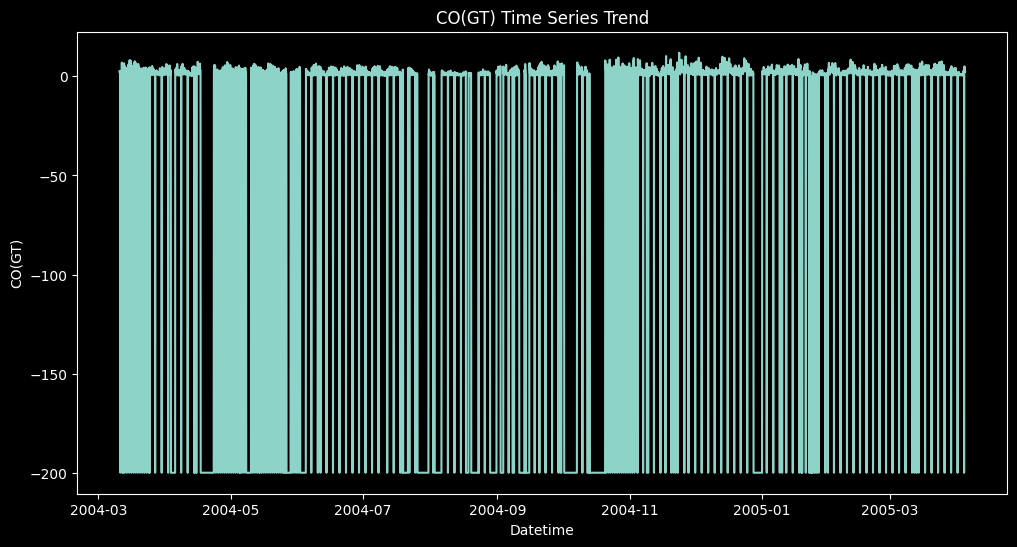

In [15]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df["CO(GT)"])

plt.title("CO(GT) Time Series Trend")
plt.xlabel("Datetime")
plt.ylabel("CO(GT)")
plt.show()

In [16]:
df.describe()

,CO(GT)
count,9357.000000
mean,-34.207524
std,77.657170
min,-200.000000
25%,0.600000
50%,1.500000
75%,2.600000
max,11.900000


In [17]:
# CO(GT) 컬럼 값이 0보다 작으면 0으로 변경
df["CO(GT)"] = df["CO(GT)"].apply(lambda x: max(x, 0))

df.describe()

,CO(GT)
count,9357.000000
mean,1.765545
std,1.554264
min,0.000000
25%,0.600000
50%,1.500000
75%,2.600000
max,11.900000


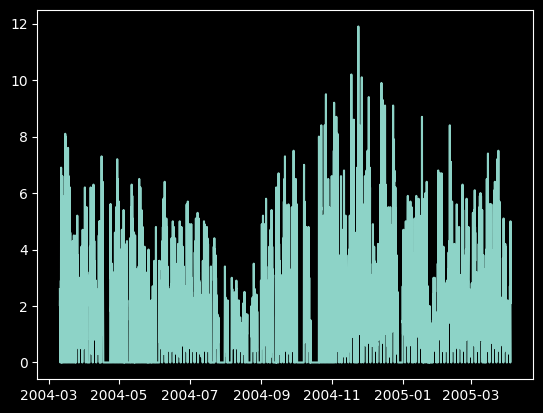

In [18]:
plt.plot(df.index, df["CO(GT)"])

**변수가 하나라도 표준화 처리가 필요한 이유**

- 수렴 속도 : 값의 범위를 작게 맞춰주면 경사하강법이 더 빨리 수렴함 
- 안정성 : 큰 값이나 작은값 때문에 모델이 불안정해지는 것을 방지 (LOSS가 진동하면서 수렴이 되지 않는 현상 발생) 

In [19]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
data = scaler.fit_transform(df)

In [20]:
data

array([[0.53691013],
       [0.15085469],
       [0.27953984],
       ...,
       [0.40822498],
       [0.21519726],
       [0.27953984]])

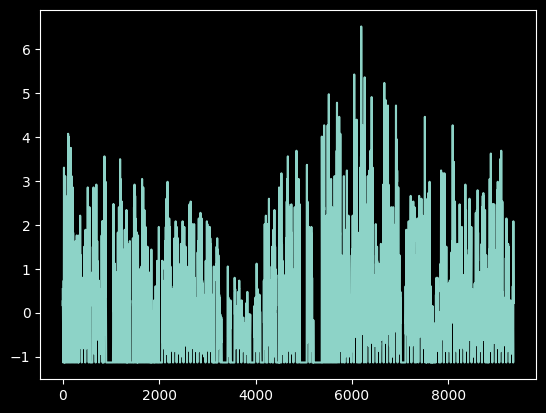

In [21]:
plt.plot(data)

**SEQ_LENGTH**

- 과거 24시간(1일) 데이터를 보고 다음 시간대의 CO 농도를 에측하도록 설정 
- 근거 : 하루(24시간) 주기가 반복되는 경향성 고려 
    - 출퇴근 시간 : 오전, 저녁에 차량 증가 -> 오염 증가 
    - 밤 시간대 : 차량 이동 적음 -> 오염 감소 

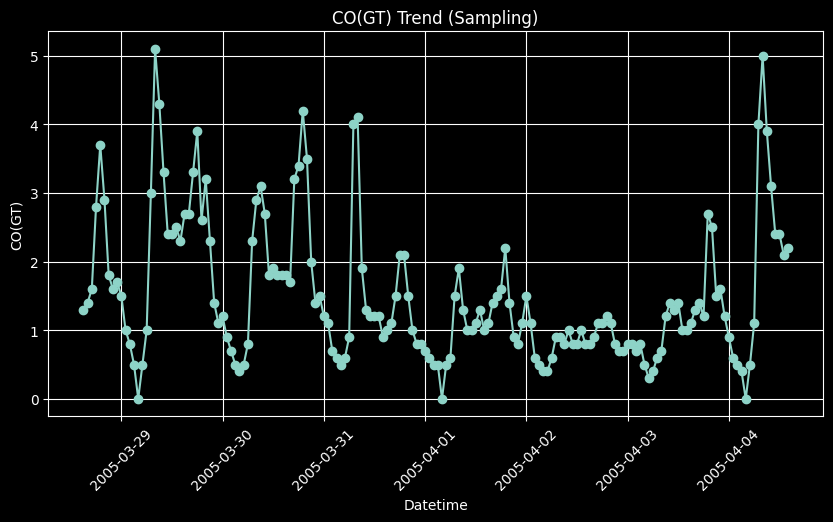

In [22]:
# 3일치 트렌드 확인
sample_days = df.last("7D")

plt.figure(figsize=(10, 5))
plt.plot(sample_days.index, sample_days["CO(GT)"], marker="o")

plt.title("CO(GT) Trend (Sampling)")
plt.xlabel("Datetime")
plt.ylabel("CO(GT)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Data Definition

In [23]:
seq_length = 24
X, y = [], []

In [24]:
for i in range(len(data) - seq_length):
    X.append(data[i : i + seq_length])
    y.append(data[i + seq_length])

X = np.array(X)
y = np.array(y)

In [25]:
print(f"X length: {len(X)}")
print(f"y length: {len(y)}")

X length: 9333
y length: 9333


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False,
)

In [27]:
len(X_test) / len(X)

0.20004285867352406

In [28]:
# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [29]:
X_train.shape

torch.Size([7466, 24, 1])

# Architecture

In [30]:
class LSTMModel(nn.Module):
    """
    LSTMModel: LSTM 기반 시계열 예측 모델
    - 입력: (batch_size, seq_length, input_size)
    - 출력: (batch_size, 1) -> 다음 시점의 CO 농도 예측
    - LSTM 내부적으로 tanh 함수가 기본 설정되어 있어 코드에 반영하지 않음
    """

    def __init__(self):
        super(LSTMModel, self).__init__()
        # LSTM 레이어 설정
        # input_size=1: 입력 특성 1개 (CO 농도)
        # hidden_size=50: 은닉 상태 벡터 차원 (기억 용량)
        # num_layers=2: LSTM 층 2개
        # batch_first=True: 입력 텐서 형태 (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=50, num_layers=2, batch_first=True
        )

        # 최종 출력 레이어
        # 50차원의 hidden state -> 1개 값 (다음 시점 CO 농도 예측)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        """
        Forward 과정
        :param x: (batch_size, seq_length, input_size)
        :return: 다음 시점의 CO 농도 (batch_size, 1)
        """
        # LSTM에 입력 시퀀스 x를 넣어서 hidden state 출력
        # out: (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x)

        # 마지막 타임스텝(hidden state)만 사용하여 예측 수행
        # out[:, -1, :] -> 마지막 시점의 hidden state만 추출
        # fc()를 통해 최종 1개 출력값으로 변환
        out = self.fc(out[:, -1, :])

        return out

# Training

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
num_epochs = 30

In [33]:
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_mse = loss.item()
    train_rmse = train_mse**0.5
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss (MSE): {train_mse:.4f}, RMSE: {train_rmse:.4f}"
    )

Epoch [1/30], Loss (MSE): 1.0644, RMSE: 1.0317
Epoch [2/30], Loss (MSE): 1.0537, RMSE: 1.0265
Epoch [3/30], Loss (MSE): 1.0438, RMSE: 1.0216
Epoch [4/30], Loss (MSE): 1.0343, RMSE: 1.0170
Epoch [5/30], Loss (MSE): 1.0252, RMSE: 1.0125
Epoch [6/30], Loss (MSE): 1.0164, RMSE: 1.0082
Epoch [7/30], Loss (MSE): 1.0076, RMSE: 1.0038
Epoch [8/30], Loss (MSE): 0.9988, RMSE: 0.9994
Epoch [9/30], Loss (MSE): 0.9897, RMSE: 0.9948
Epoch [10/30], Loss (MSE): 0.9802, RMSE: 0.9901
Epoch [11/30], Loss (MSE): 0.9701, RMSE: 0.9850
Epoch [12/30], Loss (MSE): 0.9593, RMSE: 0.9794
Epoch [13/30], Loss (MSE): 0.9475, RMSE: 0.9734
Epoch [14/30], Loss (MSE): 0.9345, RMSE: 0.9667
Epoch [15/30], Loss (MSE): 0.9201, RMSE: 0.9592
Epoch [16/30], Loss (MSE): 0.9041, RMSE: 0.9508
Epoch [17/30], Loss (MSE): 0.8864, RMSE: 0.9415
Epoch [18/30], Loss (MSE): 0.8670, RMSE: 0.9311
Epoch [19/30], Loss (MSE): 0.8460, RMSE: 0.9198
Epoch [20/30], Loss (MSE): 0.8236, RMSE: 0.9075
Epoch [21/30], Loss (MSE): 0.8005, RMSE: 0.8947
E

# Evaluation

In [34]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    predictions = predictions.view(-1, 1, 1)  # predictions 차원 맞춤
    test_loss = criterion(predictions, y_test)

In [35]:
mse = test_loss.item()
rmse = mse**0.5

print(f"Test Loss (MSE): {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test Loss (MSE): 1.1297
Test RMSE: 1.0629


# Results 

In [36]:
print(predictions.shape)
print(y_test.shape)

torch.Size([1867, 1, 1])
torch.Size([1867, 1])


In [37]:
predictions = predictions.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# 표준화 처리된 값을 원래 값으로 복구
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

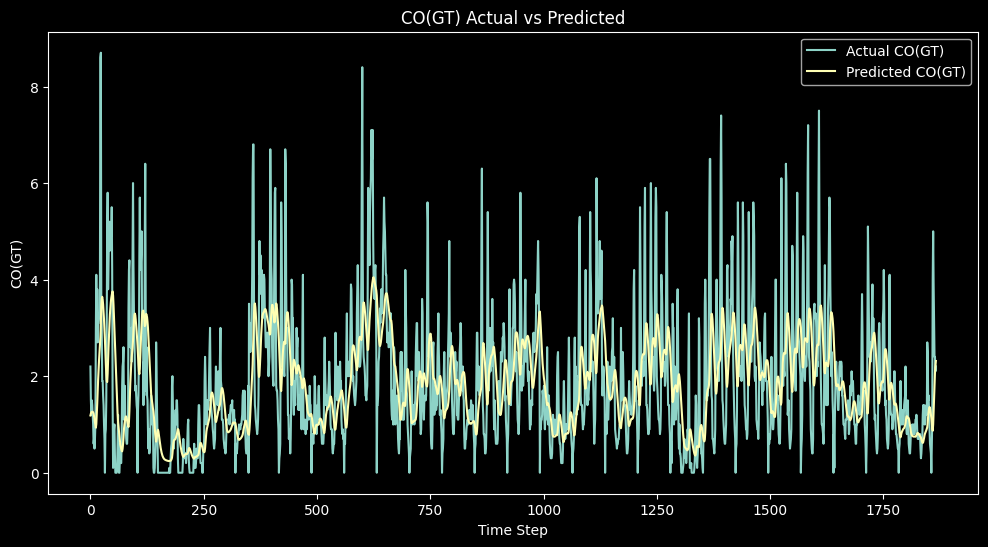

In [38]:
plt.figure(figsize=(12, 6))

plt.plot(y_test, label="Actual CO(GT)")
plt.plot(predictions, label="Predicted CO(GT)")

plt.legend()
plt.title("CO(GT) Actual vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("CO(GT)")
plt.show()

# End of Documents